In [53]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
%matplotlib inline 

# k-m experiments for Jaccard

The Jaccard index $\mathcal{J}$ on two sets $A$ and $B$ is defined as $$\mathcal{J}(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

To estimate $\mathcal{J}(A,B)$, we use a minhashing scheme as follows. Given a random hash function $h$, $h(A) = \textrm{argmin}\{h(x) \mid x \in A\}$ by definition of minhashing. Given this, $P(h(A) = h(B)) = \mathcal{J}(A, B)$ which is our intended objective. 

To compute this, we use a locality-sensitive hashing scheme. We create $m$ buckets of size $k$, where each of the $m$ buckets contains $k$ minhashes. For $A$ and $B$ to be considered "similar" within the context of their Jaccard similarity $\mathcal{J}$ (that is, within some similarity $\epsilon$), ...

Here we calculate $P(\textrm{some block} = \textrm{some block}) = 1 - (1 - \mathcal{J}(A, B)^k)^m$ and use this for tuning K and M. 


## Data
The data for this experiment the [CORA](http://www.cs.utexas.edu/users/ml/riddle/data/cora.tar.gz) citation database from UCI's [SHERLOCK](http://sherlock.ics.uci.edu/data.html) project. It is a citation database with lots of related records, good for similarity join testing. 

## Approach
As a proof-of-concept I will begin by defining record similarity on **just the title field** of the record, rather than the entire thing. The final analysis should include the entire record, but I chose a field for the purposes of understanding the concept. 

The outline of the apprach is as follows:

* Compute $n$-grams (*with what $n$?*) for all title fields in data. 
* Compute all-pairs Jaccard between all records (self-join).
* Plot $P(A, B) = 1 - (1 - \mathcal{J}(A, B)^k)^m$ for representative pair (?), with facility to choose k and m.



In [29]:
# from http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
def find_ngrams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

cora_data = pd.DataFrame.from_csv("../data/cora/cora.txt", sep='\t', header=None)
cora_data['ngram_titles'] = cora_data[4].apply(find_ngrams, n=5)

## Another Idea:




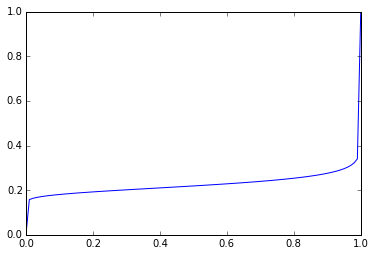

In [66]:
simspace = np.linspace(0, 1, 100)
def probsim(sim, k, m):
    return 1 - (1 - sim**k)**m

def plot_probsim(sims, k, m):
    probsfunc = np.vectorize(partial(probsim, k=k, m=m))
    probs = probsfunc(sims);
    plt.plot(sims, probs)
    

def interactfun(k, m):
    plot_probsim(simspace, k, m)
    
interact(interactfun, k=(0, 0.10,0.001), m=(0,1,0.01))
